# Bank client outflow prediction.

The [database from Kaggle.com](https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers) contains following features :
* RowNumber — row number
* CustomerId — customer identification number
* Surname — surename of a client
* CreditScore — credit score. (the higher the credit score the higher the frequency of getting a credit and returning  it)
* Geography — the origin country of a customer
* Gender — client's gender
* Age — client's age
* Tenure — how many years the client uses the banking service
* Balance — client's balance
* NumOfProducts — the number of services used by a client
* HasCrCard — whether the client has a credit card or not (1 — yes, 0 — no 
* IsActiveMember — if the client has an active member status (1 — yes, 0 — no)
* EstimatedSalary — estimated client's salary
* Exited — loyalty status, **the target value** (1 — exited client, 0 — loyal client)

In [1]:
# import main librariees
import pandas as pd
import numpy as np 
import os, sys

# Graphical libraries
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
plt.style.use('fast')

# ML libraries
from sklearn import linear_model, metrics, preprocessing, tree, ensemble
from sklearn.model_selection import train_test_split 

# set random seed
random_seed = 42

#set path
sys.path.insert(1, '../')

In [2]:
churn_data = pd.read_csv('../data/churn.zip', sep=',') 

# copy the bd to preserve the original dataset
churn_df = churn_data.copy()

# drop the useless feature RowNumber  
churn_df.drop(['RowNumber'], axis=1, inplace=True) 

# Create a new feature 'client status' to define the customers status explicitly
churn_df['client status'] = churn_df['Exited'].astype('category').cat.rename_categories({0:'Loyal', 1:'Exited'})

# drop non informative features
churn_df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

churn_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,client status
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Exited
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Loyal
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Exited
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Loyal
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Loyal


## Ratio of exited clients to loyal clients

In [3]:
# data
df=churn_df['client status'].value_counts().sort_values(ascending=False)

fig = px.pie(
    data_frame = df,
    values = 'client status',
    names = df.index,
    width=500, height=400
)

fig.update_layout(
    title=dict(text="Fig.1 - Client distribution by status", x=0.5, y=0.1, xanchor='center'),
    legend_title_text='Status:'
)
#fig.update_traces(textposition='inside', textinfo='percent+label')
#fig.show();

fig.write_image('../figures/fig_1.png', engine="kaleido")

<center> <img src = "../figures/fig_1.png"></center>

The fig.1 represents the client distribution by status. There are some 10000 clients in the database. The majority 79.6% (7963 ppl) uses the banking service though some 20.4% (2037 ppl) decided to exit the bank.

## Customer balances distribution

Let us study customer balances exceeding randomly chosen value of 2500$ (clients who actually use their accounts). 

In [4]:
fig = px.box(
    data_frame = churn_df[churn_df['Balance'] > 2500],
    x = 'Balance',
    height=250, width=700, 
)

fig.update_layout(
    title=dict(text='Fig.2 - Customer balances distribution over $2500', x=.5, y=0.05, xanchor='center'),
    xaxis_title_text = 'balance, $', yaxis_title_text = 'clients'
)

#fig.show()
fig.write_image('../figures/fig_2.png', engine="kaleido")

# number of customers:
print(f"Number of customers which balance exceeds $2500: {churn_df[churn_df['Balance'] > 2500].shape[0]} people")

Number of customers which balance exceeds $2500: 6383 people


<center> <img src = "../figures/fig_2.png">

Fig.2 represents customers balances distribution exceeding $2500. Analyzing the figure one can admit:
* there are slightly less than 6400 clients which balance exceeds $2500. 
* half of them have an amount between $100 thousands and $140 thousands.

It shows that the majority of clients are relatively wealthy and they store some $ $120.000$ $\pm$ $ $30.000$ on their accounts.

# Balance distribution and client status

In [5]:
fig = px.box(
    data_frame = churn_df,
    x = 'Balance',
    y = 'client status',
    color = 'client status',
    height=300, width=800, 
)
fig.update_layout(
    title=dict(text='Fig.3 - Customer balances distribution by status', x=.5, y=0.05, xanchor='center'),
    xaxis_title_text = 'Balance, $', yaxis_title_text = 'Status', legend_title_text='Status', 
)

#fig.show()
fig.write_image('../figures/fig_3.png', engine="kaleido")

<center> <img src = "../figures/fig_3.png">

Analizing the fig.3, representing customers balances distribution by status, it can be admitted:
* most of the exited clients stored some sufficient amount of money on their accounts whereas loyal clients have varying balance.
* the mean balance of loyal clients of $92.000 is lower than that of exited - $109.000.

This points out that wealthy clients withdraw their money at once (without decreasing it steadily).

## Age to client status

In [6]:
fig = px.box(
    data_frame = churn_df,
    x = 'Age',
    y = 'client status',
    color = 'client status',
    width=800, height=300,
)
fig.update_layout(
    title=dict(text='Fig. 4 - age to status distribution', x=.5, y=0.05, xanchor='center'),
    xaxis_title_text = 'Age of client, years', yaxis_title_text = 'Status',  
    legend_title_text='Status:'
)
#fig.show()
fig.write_image('../figures/fig_4.png', engine="kaleido")

<center> <img src = "../figures/fig_4.png">

The age to client status distribution is shown on the fig.4. One can addmitt: 
* Median age of loyal clients is 36 years. The group contains many outliers, queing outside of the right boundary;
* Median age of the exited clients is 45 years. A half of them can be named as a 'risky age group' is within the range between 38 and 51 years. The bank managers should point attention to this age group.

## Credit rating vs estimated salary

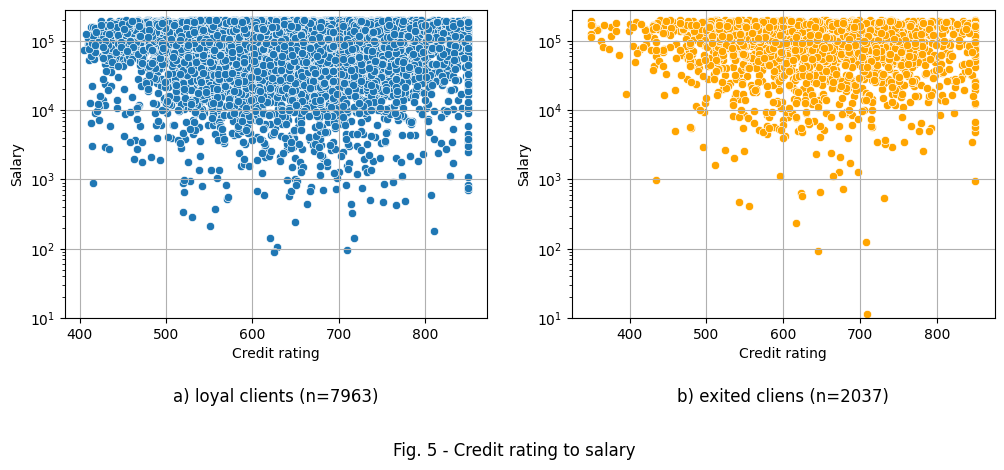

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# diagram1
sns.scatterplot(
    data=churn_df[churn_df['client status'] == 'Loyal'],
    x='CreditScore',
    y='EstimatedSalary', #marker="+",
    ax=ax[0]    
    ); 
# logarythmic scale
ax[0].set(yscale="log") #xscale="log"
ax[0].set_ylim(10, 2.8*10e4)
ax[0].set_xlabel('Credit rating')
ax[0].set_ylabel('Salary')
ax[0].grid();

# diagram2 
sns.scatterplot(
    data=churn_df[churn_df['client status'] == 'Exited'], #
    x='CreditScore',
    y='EstimatedSalary', 
    ax=ax[1],
    color='orange',
    ); 

# логарифмическая шкала по оси У
ax[1].set(yscale="log",) #xscale="log"
ax[1].set_ylim(10, 2.8*10e4)

ax[1].set_xlabel('Credit rating')
ax[1].set_ylabel('Salary')

ax[1].grid()

fig.suptitle('Fig. 5 - Credit rating to salary', fontsize=12, y=-0.20)
ax[0].set_title('a) loyal clients (n=7963)',y=-0.30,loc='center') #, , 
ax[1].set_title('b) exited cliens (n=2037)',y=-0.30,loc='center'); #, loc='center', y=-0.1

plt.savefig(f'../figures/fig_5.png')

Analyzing the credit rating to salary distribution on fig.5 it can be inferred:
* the rating does not correlate with salary in general. It implies that most of the client use the credit program.
* most of clients despite status are supposed to have salary between 100090 $\pm$ 57510 usd.

## Exited clients genders

In [8]:
df=churn_df[churn_df['client status'] == 'Exited']['Gender'].value_counts()

fig = px.pie(
    data_frame = df,
    values = 'Gender',
    names = df.index,
    width=400, height=300,
)

fig.update_layout(
    title=dict(text='Fig.6 - Genders of exited clients', x=.5, y=0.1, xanchor='center'),
    legend_title_text='Gender:'
)
#fig.show()
fig.write_image('../figures/fig_6.png', engine="kaleido");

# encoding
churn_df['Gender'] = churn_df['Gender'].apply(lambda x: 1 if x == 'Male' else '0')

<center> <img src = "../figures/fig_6.png">

Analyzing the fig.6 it can be addmitted, that women leave the bank more often than men.

## Number of services vs status

In [9]:
df = churn_df.groupby(['NumOfProducts', 'Exited'], as_index=False).count()

fig = px.bar(
    data_frame=df,
    x='NumOfProducts',
    y='client status',
    color='Exited',
    height=400,
    width=600,
    labels={'NumOfProducts':'Number of products',"client status":'Number of clients'},
    category_orders={'Exited': [1, 0]},
)

fig.update_layout(
    title=dict(text='Fig.7 - Services used by exit clients', x=.5, y=0.05, xanchor='center'),
    bargap=0.2
    #legend_title_text='Gender:'
)

#fig.show()
fig.write_image('../figures/fig_7.png', engine="kaleido")

<center> <img src = "../figures/fig_7.png"> </center>

The fig.7 represents the number of services used by clients in relation to their status. Analyzing the chart one can admit:
* loyal clients used bank services in average 3 times more actively than exited clients in general. 
* most of clients use up to 2 products. 
 
The figure indicates that exited clients were unsatisfied with the number of services or its quality.

## Active client status vs status

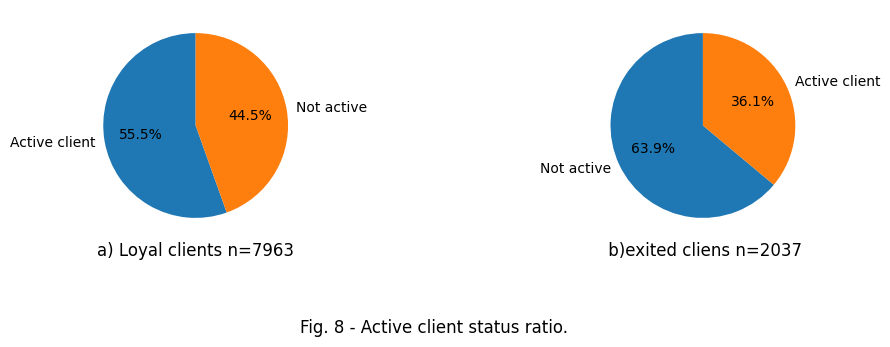

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3)) 
labels = 'Active client', 'Not active'
labels1 =  'Not active', 'Active client'

ax1.pie(
    churn_df[churn_df['client status'] == 'Loyal']['IsActiveMember'].value_counts().sort_values(ascending=False),
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
)


ax2.pie(
    churn_df[churn_df['client status'] == 'Exited']['IsActiveMember'].value_counts().sort_values(ascending=False),
    labels=labels1,
    autopct='%1.1f%%',
    startangle=90,
)

fig.suptitle('Fig. 8 - Active client status ratio.', fontsize=12, y=-0.15)
ax1.set_title('a) Loyal clients n=7963', loc='center', y=-0.1)
ax2.set_title(' b)exited cliens n=2037', loc='center', y=-0.1);

The fig.8 represent the active client status distribution by the bank usage status. As it can be seen from the charts loyal clients are more prone to have an 'active clients' unlike exited clients. It indicates that exited clients were more passive and most likely to use their accounts for savings.

# Exited clients distribution by country

In [11]:
#df = churn_data.groupby(['Geography'], as_index=False).mean(numeric_only=True)
df = churn_df[churn_df['Exited']==1].groupby(by='Geography', as_index=False).agg('count')
#Количество 
display(df[['Geography', 'Exited']])

# построим картограмму с помощью библиотеки Plotly
fig = px.choropleth(
    df,
    locations="Geography",
    locationmode = "country names",
    color='Exited', 
    width=600,
    height=400,
    color_continuous_scale="Peach", # Burg
    scope='europe',
)
fig.update_layout(title=dict(text='Fig. 9 - Exited clients distribution by country', x=.5, y=0.05, xanchor='center')
)
fig.update_geos(
    center=dict(lon=2, lat=50),
    lataxis_range=[-5,20], 
    lonaxis_range=[38, 51]
)

fig.show()
fig.write_image('../figures/fig_9.png', engine="kaleido")

,Geography,Exited
0,France,810
1,Germany,814
2,Spain,413


<center> <img src = "../figures/fig_9.png"> </center>

Fig 9 represent clients status distribution by countries. Analyzing the diagram one can conclude that exited clients live in following countries: Germany(40%) , France(40%), Spain(20%)

# Credit score vs tenure

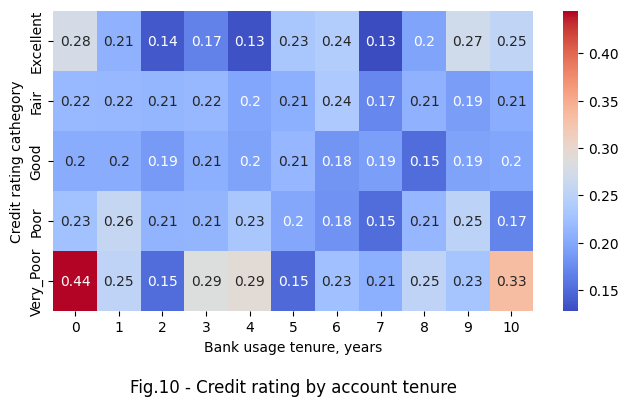

In [12]:
# rating split by 5 groups
def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score >= 851:
        return "Top"
    elif credit_score < 300:
        return "Deep"
    
# Create a new feature 'CreditScoreCat'
churn_df['CreditScoreCat'] = churn_df['CreditScore'].apply(get_credit_score_cat) 

fig = plt.figure(figsize=(6, 3))
ax = fig.add_axes((0, 0, 1, 1))

df = churn_df.pivot_table(values='Exited', index='CreditScoreCat', columns='Tenure', aggfunc='mean')

sns.heatmap(df, annot=True, cmap= 'coolwarm'); #linewidths=.05

ax.set_title('Fig.10 - Credit rating by account tenure', fontsize=12, y=-0.3)
ax.set_xlabel('Bank usage tenure, years')
ax.set_ylabel('Credit rating cathegory');

plt.savefig(f'../figures/fig_10.png')

Fig.10 represents the credit rating distribution by account tenure in years. Analyzing the figure it can be noted:
* clients with a very poor credit rating are prone to leave the bank despite their account tenure. Maximum probability of exiting is noted within the years: 0, 3, 4 and 10.
* clients in other groups do not show significant tendency to exit

It can be recommended to point attention on that customer group.

## Correlation between features

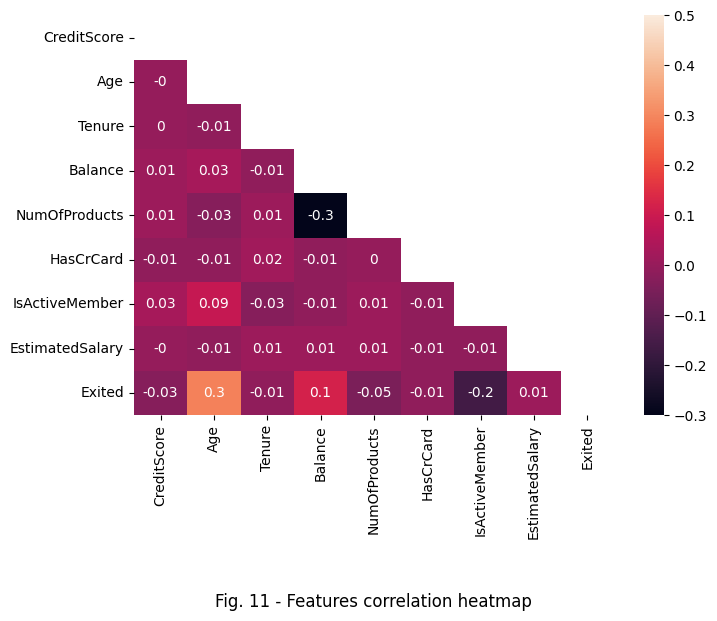

In [13]:
# let us delete repetitive features
churn_df.drop(['client status', 'CreditScoreCat'], axis=1, inplace=True)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0, 0, 1, 1))
matrix = np.triu(churn_df.corr(numeric_only=True))

fig = sns.heatmap(churn_df.corr(numeric_only=True).round(2), annot=True, fmt='.1g', vmax=0.5, mask=matrix) #, vmax=0.3
ax.set_title('Fig. 11 - Features correlation heatmap', fontsize=12, y=-0.5);

As it can be seen from the heatmap on the fig. 11 one can admit:
* the correlation values do not exceed some 0.3. Thus, there is no multicollinearity between features
* maximal positive correlation is observed between the client's age and his status (target value). One can say elder clients leave the bank;
* maximal negative correlation is observed between the client's balance  and the Number of products. The higher the balance the lower the number of services used by the client.


# Feature Engineering.

Let us create new features:
* BalanceSalaryRatio — balance to salary ratio;
* TenureByAge — tenure by age ratio;
* CreditScoreGivenAge — credit ration to age ratio.

In [38]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.047619,14.738095
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.744677,0.024390,14.829268
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.401375,0.190476,11.952381
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.025641,17.923077
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587055,0.046512,19.767442


# Modelling: Germany

Suppose causes of the client outflow are varying by country. So let us create different models for each county. 

In [14]:
churn_data_cleaned = churn_df[churn_df['Geography'] == 'Germany']
print('Shape:', churn_data_cleaned.shape)
# (2509, 14)
churn_data_cleaned.head()

Shape: (2509, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Germany,0,29,4,115046.74,4,1,0,119346.88,1
15,616,Germany,1,45,3,143129.41,2,0,1,64327.26,0
16,653,Germany,1,58,1,132602.88,1,1,0,5097.67,1
26,756,Germany,1,36,2,136815.64,1,1,1,170041.95,0
28,574,Germany,0,43,3,141349.43,1,1,1,100187.43,0


Let us delete non informative features.

In [15]:
churn_data_cleaned = churn_data_cleaned.drop(['Geography', 'Gender'], axis=1).rename(columns={'Пол':'Gender'}) #delete and rename features
print('Shape:', churn_data_cleaned.shape)
churn_data_cleaned.head()

Shape: (2509, 9)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,29,4,115046.74,4,1,0,119346.88,1
15,616,45,3,143129.41,2,0,1,64327.26,0
16,653,58,1,132602.88,1,1,0,5097.67,1
26,756,36,2,136815.64,1,1,1,170041.95,0
28,574,43,3,141349.43,1,1,1,100187.43,0


### Check for missed data.

In [16]:
churn_data_cleaned.isnull().sum()

CreditScore        0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Let us assign the target to a separate variable

In [18]:
X, y = churn_data_cleaned.drop("Exited", axis=1), churn_data_cleaned["Exited"]

Normalization

In [19]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Let us study classes in target value.

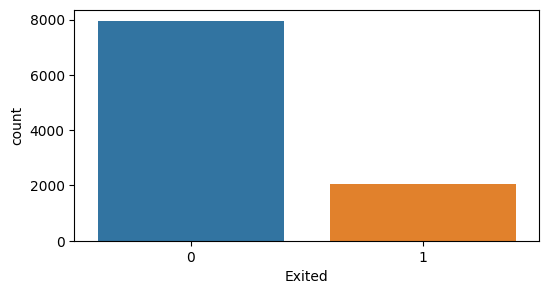

In [20]:
y.value_counts(normalize=True)

fig = plt.figure(figsize=(6, 3))
sns.countplot(data = churn_data, x='Exited');

As we can see from the histogram, data classes in the target value are unbalances. Therefore, we shall use straitfied 
split method.

## Model logistic regression
We will use $F1$-score to reach balance between $precision$ and $recall$ since we have unbalanced classes.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0) #random_seed

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))


Train shape: (1881, 11)
Test shape: (628, 11)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [22]:
print('Train :\n', y_train.value_counts(normalize=True).round(2))
print('Test :\n', y_test.value_counts(normalize=True).round(2))

Train :
 0    0.68
1    0.32
Name: Exited, dtype: float64


Test :
 0    0.68
1    0.32
Name: Exited, dtype: float64


### Логистическая регрессия

In [23]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #optimization algorythm
    class_weight='balanced', # balancing classes weights
    random_state=0, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0,
                   solver='sag')

In [24]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

#print('F1 score for train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1 score for test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.82      0.68      0.74      1271
           1       0.50      0.69      0.58       610

    accuracy                           0.68      1881
   macro avg       0.66      0.68      0.66      1881
weighted avg       0.72      0.68      0.69      1881

              precision    recall  f1-score   support

           0       0.82      0.66      0.73       424
           1       0.50      0.71      0.59       204

    accuracy                           0.67       628
   macro avg       0.66      0.68      0.66       628
weighted avg       0.72      0.67      0.68       628

F1 score for test: 0.59


### Polynomial regression of 3d power

In [25]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

print(f'Кол-во признаков в тренировочной выборке:',X_train_poly.shape[1])

(1881, 363)
(628, 363)
Кол-во признаков в тренировочной выборке: 363


In [26]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_poly, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [27]:
#Выводим отчет по метрикам для тренировочной и тестовой выборок
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

print('F1-score в тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1-score в тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1271
           1       0.79      0.55      0.65       610

    accuracy                           0.81      1881
   macro avg       0.80      0.74      0.76      1881
weighted avg       0.80      0.81      0.80      1881

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       424
           1       0.74      0.53      0.62       204

    accuracy                           0.79       628
   macro avg       0.77      0.72      0.73       628
weighted avg       0.78      0.79      0.78       628

F1-score в тренировочной выборке: 0.65
F1-score в тренировочной выборке: 0.62


### Оптимизация порога вероятности полиноминальной модели

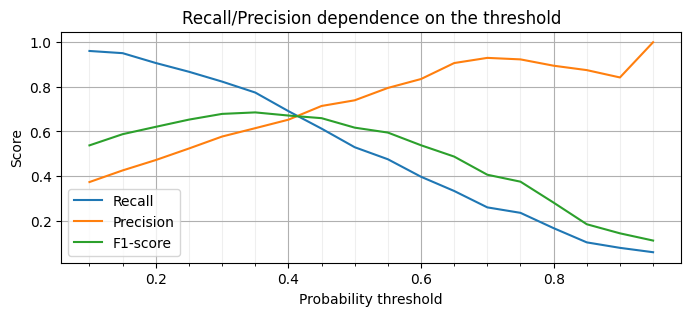

In [28]:
#Считаем вероятности оттока клиентов
y_test_proba_pred = log_reg.predict_proba(X_test_poly)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(8, 3)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

# Major ticks every 20, minor ticks every 5
#major_ticks = np.arange(0, 101, 20)
minor_ticks = np.arange(0, 1, 0.05)
ax.set_xticks(minor_ticks, minor=True)

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Отображаем легенду
ax.legend()
ax.grid()
ax.grid(which='minor', alpha=0.2);

Мы видим на графике:

С увеличением вероятностного порога (treshhold) повышается precision и падает recall. Это означает, что при увеличении порога вероятности мы начинаем классифицировать в качестве "уходящих" тех клиентов клиентов, признаки которых чётче указывают на желание покинуть банк. Таким образом, повышая точность (precision) мы уменьшаем охват (recall).

При этом значение $F1$-меры сначала немного повышается, а затем неуклонно падает. 

В точке threshold=0.43 происходит пересечение всех трёх графиков.  

Однако максимум  $F1$-меры достигается в другой точке — threshold=0.3. При этом значения recall и precision в этой точке различны: recall выше, а вот precision ниже.

In [29]:
thresholds_scores_df = pd.DataFrame({'thresh':thresholds, 'f1-scores':f1_scores}) #.reset_index()
thresholds_scores_df.sort_values(by='f1-scores', ascending=False).head(1)

,thresh,f1-scores
5,0.35,0.685466


In [30]:
best = pd.DataFrame({'thresh':thresholds, 'precision_scores':precision_scores, 'recall_scores':recall_scores}) #.reset_index()
best['best_score'] = best['precision_scores'] - best['recall_scores']
best[['thresh', 'best_score']]

,thresh,best_score
0,0.10,-0.587451
1,0.15,-0.525542
2,0.20,-0.434924
3,0.25,-0.343978
4,0.30,-0.246210
5,0.35,-0.159724
6,0.40,-0.038399
7,0.45,0.101541
8,0.50,0.210314
9,0.55,0.319592


In [31]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35
#Пациентов, для которых вероятность наличия диабета > 0.35 относим к классу 1
#В противном случае - к классу 0
y_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       424
           1       0.61      0.77      0.69       204

    accuracy                           0.77       628
   macro avg       0.75      0.77      0.75       628
weighted avg       0.79      0.77      0.77       628



### Модель Дерево решений

In [32]:
#Создаём объект класса DecisionTreeClassifier
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    max_depth=8, #максимальная глубина
    min_samples_leaf = 10, # Минимальное число объектов в листе
    random_state=random_seed #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt.fit(X_train, y_train)

#Делаем предсказание класса для тренировочной выборки
y_pred_train = dt.predict(X_train)
#Выводим отчет о метриках
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))

#Делаем предсказание класса для тестовой выборки
y_pred_test = dt.predict(X_test)
#Выводим отчет о метриках
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

Train: 0.72
Test: 0.66


### Случайный лес

In [33]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=8, #максимальная глубина дерева
    min_samples_leaf = 10, # Минимальное число объектов в листе
    #max_features='sqrt', #число признаков из метода случайных подространств
    random_state=random_seed #генератор случайных чисел
)
#Обучаем модель 
rf.fit(X_train, y_train)

#Делаем предсказание класса для тренировочной выборки
y_pred_train = rf.predict(X_train)
#Выводим отчет о метриках
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))

#Делаем предсказание класса для тестовой выборки
y_pred_test = rf.predict(X_test)
#Выводим отчет о метриках
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

Train: 0.73
Test: 0.65


In [34]:
#Считаем вероятности оттока клиентов модели случайный лес
y_test_proba_pred = rf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
#y_test_proba_pred = pd.Series(y_test_proba_pred)
#y_test_proba_pred.head()

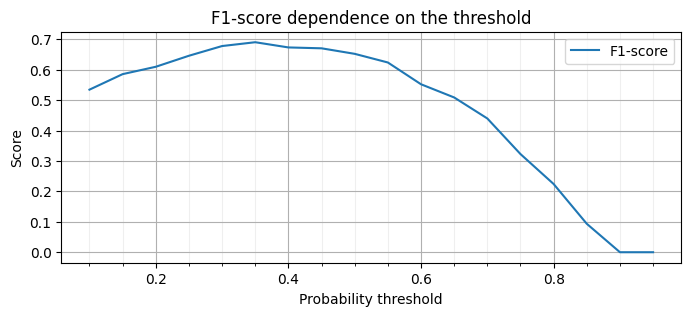

In [35]:
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Клиентов, для которых вероятность оттока > threshold относим к классу 1. В противном случае - к классу 0
    #y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    y_test_pred = np.where(y_test_proba_pred>threshold, 1, 0)
    
    #Считаем метрики и добавляем их в списки
    #recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    #precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(8, 3)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
#ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
#ax.plot(thresholds, precision_scores, label='Precision')

minor_ticks = np.arange(0, 1, 0.05)
ax.set_xticks(minor_ticks, minor=True)
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('F1-score dependence on the threshold') # Recall/Precision dependence on the threshold
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Отображаем легенду
ax.legend()
ax.grid()
ax.grid(which='minor', alpha=0.2);

In [36]:
# Maximal F1-score
max_f1_score = max(f1_scores)

# transform list of f1-scores to array
f1_scores = np.array(f1_scores).round(3)

# The probability value of the best f1-score value
threshold_opt = round(0.05 + (np.argmax(f1_scores) + 1)*0.05, 2)
print(f'Best F1-score: {max_f1_score.round(3)}, Maximal probability: {threshold_opt}')

Best F1-score: 0.69, Maximal probability: 0.35


In [37]:
#Задаем оптимальный порог вероятностей
threshold_opt = threshold_opt
#Клиентов, для которых вероятность оттока > threshold относим к классу 1. В противном случае - к классу 0
#y_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0) # в pandas
y_test_pred = np.where(y_test_proba_pred > threshold, 1, 0)  # в numpy
#Считаем метрики
print(metrics.classification_report(y_test, y_pred_opt))
print('F1-score:', metrics.f1_score(y_test, y_pred_opt).round(3))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       424
           1       0.61      0.77      0.69       204

    accuracy                           0.77       628
   macro avg       0.75      0.77      0.75       628
weighted avg       0.79      0.77      0.77       628

F1-score: 0.685


Выводы: